In [1]:
import pandas as pd
import altair as alt
import pymc3 as pm
import numpy as np
import arviz as az
import matplotlib
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline


# Introduction

The goal of this analysis is to find a model that fits the observed cumulative cases of COVID-19 in the US, starting in Mid-July 2021 and ending in late November 2021. Mid-July coincides with the introduction and subsequent domination of the delta variant of COVID-19 and late November is the latest data released by the World Health Organization at the time of writing. The data used for this project is made freely available by the World Health Organization (WHO) [here](https://covid19.who.int/info?openIndex=2). The first section includes exploratory data analysis and formatting. The second section includes several helper functions for plotting data and results. The third section is comprised of the candidate models defined in increasing levels of complexity. The final section is the comparison and conclusion.

In [2]:
# Read in WHO Covid Case reporting data
cases = pd.read_csv("./data/WHO-COVID-19-global-data.csv")

# Filter Data by United States and format dates
us = cases.loc[cases.Country == "United States of America"].copy()
us.Date_reported = pd.to_datetime(us.Date_reported, format="%Y-%m-%d")

us


Date_reported Country_code                   Country WHO_region  \
156844    2020-01-03           US  United States of America       AMRO   
156845    2020-01-04           US  United States of America       AMRO   
156846    2020-01-05           US  United States of America       AMRO   
156847    2020-01-06           US  United States of America       AMRO   
156848    2020-01-07           US  United States of America       AMRO   
...              ...          ...                       ...        ...   
157533    2021-11-22           US  United States of America       AMRO   
157534    2021-11-23           US  United States of America       AMRO   
157535    2021-11-24           US  United States of America       AMRO   
157536    2021-11-25           US  United States of America       AMRO   
157537    2021-11-26           US  United States of America       AMRO   

        New_cases  Cumulative_cases  New_deaths  Cumulative_deaths  
156844          0                 0           0                  0  
156845          0                 0           0                  0  
156846          0                 0           0                  0  
156847          0                 0           0                  0  
156848          0                 0           0                  0  
...           ...               ...         ...                ...  
157533      32331          47405130         269             767185  
157534      32036          47437166         111             767296  
157535     162130          47599296        1269             768565  
157536     102708          47702004        1597             770162  
157537     100455          47802459        1367             771529  

[694 rows x 8 columns]

In [3]:
# Plot Side by Side Charts of New cases and Cumulative Cases
alt.Chart(us).mark_line().encode(x="Date_reported:T", y="New_cases") | alt.Chart(
    us
).mark_line().encode(x="Date_reported:T", y="Cumulative_cases")


alt.HConcatChart(...)

In [4]:
# Interested in the Cases increase when Delta became the Dominant strain in the US ~ July 15th 2021
us_delta = us.loc[us.Date_reported > pd.Timestamp("07-15-2021")].copy()

# Reseting Cumulative Cases to 0: Only INterested in new Caes during the "Delta Wave" of Covid in the US
us_delta["new_cumulative_cases"] = (
    us_delta.Cumulative_cases - us_delta.Cumulative_cases.min()
)

alt.Chart(us_delta).mark_line().encode(x="Date_reported:T", y="New_cases") | alt.Chart(
    us_delta
).mark_line().encode(x="Date_reported:T", y="new_cumulative_cases")


alt.HConcatChart(...)

In [5]:
# Finding max cases, and the day on which it occured
max_cases = us_delta.New_cases.max()
us_delta.loc[us_delta.New_cases == max_cases]

max_cases_day = us_delta.loc[us_delta.New_cases == max_cases].Date_reported
max_cases_day.values[0]


Date_reported Country_code                   Country WHO_region  \
157453    2021-09-03           US  United States of America       AMRO   

        New_cases  Cumulative_cases  New_deaths  Cumulative_deaths  \
157453     198453          39317981        1994             646132   

        new_cumulative_cases  
157453               5505296

numpy.datetime64('2021-09-03T00:00:00.000000000')

In [6]:
# Finding Average new cases per day
us_delta.New_cases.mean()


104687.57462686567

## Observations:

* When zoomed in like this, the cumulative cases during this timeframe appear almost logistic. 
* Rapid, exponential growth initially, then a leveling off.
* The average number of new cases per day is close to 100,000

In [7]:
# Preparing data for modeling

# Scaling Cases
us_delta.Cumulative_cases /= 1000
us_delta.new_cumulative_cases /= 1000
us_delta.New_cases /= 1000

# Creating a "Number of days t since start" column
us_delta["t"] = us_delta.Date_reported - us_delta.Date_reported.min()
us_delta["t"] = us_delta.t.dt.days

# Filtering cases to include only days up to peak in early september
us_delta_until_peak = us_delta.loc[us_delta.Date_reported < max_cases_day.values[0]]


In [8]:
us_delta.shape
us_delta_until_peak.shape

print("Maximum number of cases after scaling: ", us_delta.new_cumulative_cases.max())


(134, 10)

(49, 10)

Maximum number of cases after scaling:  13989.774


# Several Helper Functions for plotting

In [9]:
# Defineing Function for Plotting Posterior Predicitons
def plot_post_pred_log(
    post_pred: dict, var_name: str = "obs", num_series=100, upper_bound=50_000
) -> alt.Chart:
    # Get var from post_pred dict obj - convert to long df
    post_obs = pd.DataFrame(post_pred[var_name].T)
    post_obs_long = post_obs.reset_index().melt(
        "index", var_name="series", value_name="obs"
    )
    post_obs_long.columns = ["t", "series", "cases"]
    print(post_obs_long.loc[post_obs_long.series < num_series].shape)
    posterior_pred_chart = (
        alt.Chart(
            post_obs_long.loc[
                (post_obs_long.series < num_series) & (post_obs_long.cases > 0)
            ]
        )
        .mark_line()
        .encode(
            alt.X("t"),
            alt.Y(
                "cases",
                scale=alt.Scale(type="log", domain=(1, upper_bound)),
                axis=alt.Axis(tickCount=5),
            ),
            detail="series",
            opacity=alt.value(0.2),
            color=alt.value("grey"),
        )
    )

    observed_line = (
        alt.Chart(
            # ploting on log scale requires removal of 0's
            us_delta.loc[
                us_delta.new_cumulative_cases != 0, ["t", "new_cumulative_cases"]
            ]
        )
        .mark_line()
        .encode(
            alt.Y(
                "new_cumulative_cases",
                scale=alt.Scale(type="log", domain=(1, upper_bound)),
                axis=alt.Axis(tickCount=5),
            ),
            alt.X("t"),
        )
    )

    return posterior_pred_chart + observed_line


def plot_post_pred_linear(
    post_pred: dict, var_name: str = "obs", num_series=100, upper_bound=50_000
) -> alt.Chart:
    # Get var from post_pred dict obj - convert to long df
    post_obs = pd.DataFrame(post_pred[var_name].T)
    post_obs_long = post_obs.reset_index().melt(
        "index", var_name="series", value_name="obs"
    )
    post_obs_long.columns = ["t", "series", "cases"]

    posterior_pred_chart = (
        alt.Chart(post_obs_long.loc[post_obs_long.series < num_series])
        .mark_line()
        .encode(
            alt.X("t"),
            alt.Y("cases", scale=alt.Scale(domain=(1, upper_bound)),),
            detail="series",
            opacity=alt.value(0.2),
            color=alt.value("grey"),
        )
    )

    observed_line = (
        alt.Chart(
            # ploting on log scale requires removal of 0's
            us_delta.loc[
                us_delta.new_cumulative_cases != 0, ["t", "new_cumulative_cases"]
            ]
        )
        .mark_line()
        .encode(
            alt.Y("new_cumulative_cases", scale=alt.Scale(domain=(1, upper_bound)),),
            alt.X("t"),
        )
    )

    return posterior_pred_chart + observed_line


def plot_post_pred(
    post_pred: dict, var_name: str = "obs", num_series=100, upper_bound=50_000
) -> alt.Chart:
    return plot_post_pred_log(
        post_pred, var_name, num_series, upper_bound
    ) | plot_post_pred_linear(post_pred, var_name, num_series, upper_bound)



In [10]:
def plot_residuals(post_pred, var_name="obs", num_series=100) -> alt.Chart:
    residuals = post_pred[var_name].T - us_delta[["new_cumulative_cases"]].values
    resid_long = (
        pd.DataFrame(residuals)
        .reset_index()
        .melt("index", var_name="series", value_name=var_name)
    )
    resid_long.columns = ["t", "series", "cases"]
    print(resid_long.loc[resid_long.series < num_series].shape)

    improved_resids_chart = (
        alt.Chart(resid_long.loc[(resid_long.series < num_series)])
        .mark_line()
        .encode(
            alt.X("t"),
            alt.Y("cases",),
            detail="series",
            opacity=alt.value(0.2),
            color=alt.value("grey"),
        )
    )

    return improved_resids_chart


# Candidate Models

For each model, the trace, energy, and model summaries are printed. Model summaries include means and credible sets for each parameter. Each parameter is defined in the cell that begins with: "with pm.Model() as ..." and is described briefly in the comment above. After each model is sampled and summarized, the model's posterior is printed in log and linear scale overlayed with original data. Residuals are also plotted below.

In [11]:
with pm.Model() as linear_normal_model:
    # Define priors: We know the intercept should be 0,
    #   therefore the variance around the intercept should be small
    tau_1 = pm.Gamma("tau_1", alpha=1, beta=10)

    # We know the precision on the slope will be very small
    #   since there is a strong linear, albeit curvy, relationship
    #   given the cumulative nature of the data
    tau_2 = pm.Gamma("tau_2", alpha=1, beta=0.1)

    # Intercept - Can't have negative cumulative cases, therefore
    #  We are safe to bound the normal distribution above 0
    intercept = pm.HalfNormal("intercept", tau=tau_1)

    # Slope - Can't have negative slope of cumulative cases
    #    Unsure of slope, noninformative priors
    beta = pm.Bound(pm.Normal, lower=0)("beta", mu=100, tau=tau_2)

    # linear model of growth
    growth = intercept + beta * us_delta.t.values

    # Errors
    e = pm.HalfNormal("e", tau=1e-5)

    # Normal Likelihood
    pm.Normal("obs", mu=growth, sigma=e, observed=us_delta.new_cumulative_cases.values)



obs ~ Normal

In [12]:
with linear_normal_model:
    linear_normal_trace = pm.sample(
        chains=4, cores=4, return_inferencedata=True, tune=1000
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e, beta, intercept, tau_2, tau_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot:title={'center':'tau_1'}>,
        <AxesSubplot:title={'center':'tau_1'}>],
       [<AxesSubplot:title={'center':'tau_2'}>,
        <AxesSubplot:title={'center':'tau_2'}>],
       [<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'e'}>,
        <AxesSubplot:title={'center':'e'}>]], dtype=object)

<AxesSubplot:>

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau_1        0.102   0.099    0.000    0.285      0.002    0.001    1847.0   
tau_2        0.027   0.023    0.000    0.069      0.000    0.000    1805.0   
intercept    3.504   4.168    0.001    9.589      0.097    0.069    1559.0   
beta       110.560   0.624  109.436  111.761      0.012    0.009    2605.0   
e          566.568  34.395  502.465  630.767      0.729    0.519    2277.0   

           ess_tail  r_hat  
tau_1        1419.0    1.0  
tau_2        1239.0    1.0  
intercept    1233.0    1.0  
beta         2420.0    1.0  
e            2056.0    1.0

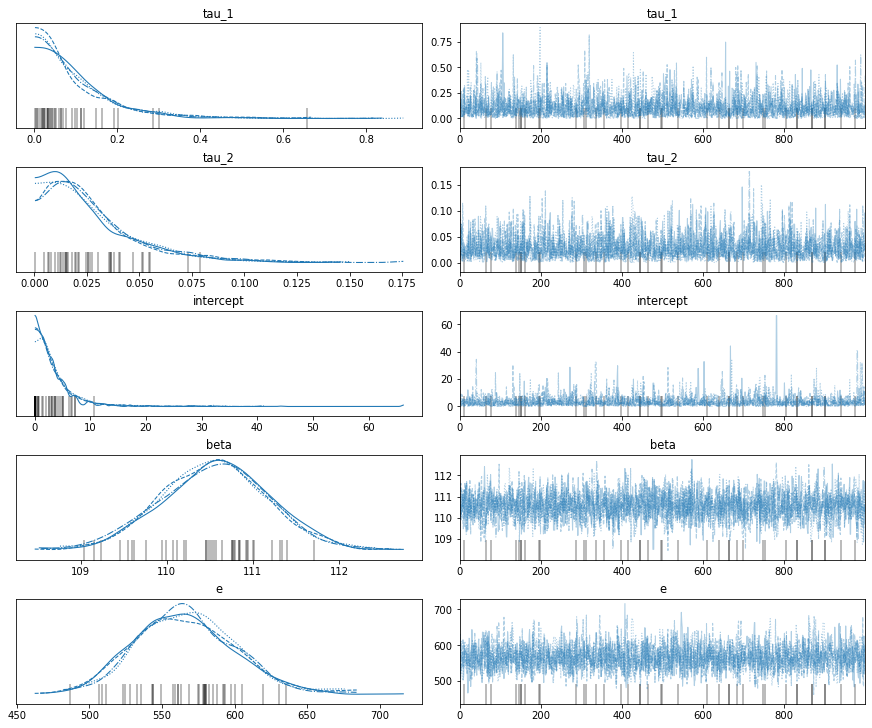

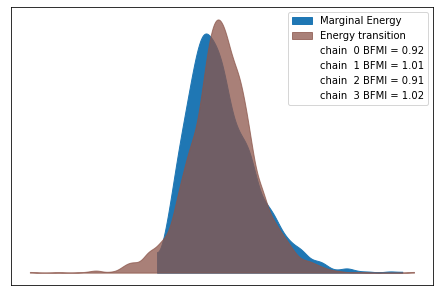

In [13]:
az.plot_trace(linear_normal_trace)
az.plot_energy(linear_normal_trace)
az.summary(linear_normal_trace)


In [14]:
with linear_normal_model:
    linear_normal_post_pred = pm.sample_posterior_predictive(
        linear_normal_trace.posterior
    )


In [15]:
plot_post_pred(linear_normal_post_pred, num_series=30, upper_bound=17_000)


(4020, 3)


alt.HConcatChart(...)

In [16]:
plot_residuals(linear_normal_post_pred, num_series=30)


(4020, 3)


alt.Chart(...)

In [17]:
with pm.Model() as linear_neg_binomial_model:
    # Define priors: We know the intercept should be 0,
    #   therefore the variance around the intercept should be small
    tau_1 = pm.Gamma("tau_1", alpha=1, beta=10)

    # We know the precision on the slope will be very small
    #   since there is a strong linear, albeit curvy, relationship
    #   given the cumulative nature of the data
    tau_2 = pm.Gamma("tau_2", alpha=1, beta=0.1)

    # Intercept - Can't have negative cumulative cases
    intercept = pm.HalfNormal("intercept", tau=tau_1)

    # Slope - Can't have negative slope of cumulative cases
    #    Unsure of slope, noninformative priors
    beta = pm.Bound(pm.Normal, lower=0)("beta", mu=100, tau=tau_2)

    # linear regression
    growth = intercept + beta * us_delta.t.values

    # # Errors
    # e = pm.HalfNormal('e', tau =1e-5)

    # # Likelihood
    # pm.Normal('obs', mu= growth, sigma = e, observed = us_delta.new_cumulative_cases.values)

    # Error/spread term as a gamma distribution rather than normal
    #    for new likelihood function
    alpha = pm.Gamma("alpha", alpha=10, beta=1)

    # Negative Binomial Likelihood with gamma prior on alpha
    #   should be more appropiate to this problem than the previous
    #   since obs is a count (discrete), that is larger than 0.
    pm.NegativeBinomial(
        "obs", mu=growth, alpha=alpha, observed=us_delta.new_cumulative_cases.values
    )


obs ~ NegativeBinomial

In [18]:
with linear_neg_binomial_model:
    linear_neg_binomial_trace = pm.sample(
        chains=4, cores=4, return_inferencedata=True, tune=1000
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, intercept, tau_2, tau_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot:title={'center':'tau_1'}>,
        <AxesSubplot:title={'center':'tau_1'}>],
       [<AxesSubplot:title={'center':'tau_2'}>,
        <AxesSubplot:title={'center':'tau_2'}>],
       [<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

<AxesSubplot:>

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau_1       0.147  0.114   0.001    0.356      0.003    0.002    1414.0   
tau_2      10.365  9.893   0.012   29.027      0.276    0.196    1057.0   
intercept   0.761  0.758   0.000    2.167      0.016    0.012    1338.0   
beta       99.979  0.527  99.039  101.022      0.016    0.011    1476.0   
alpha      12.530  1.502   9.837   15.369      0.037    0.026    1594.0   

           ess_tail  r_hat  
tau_1        1057.0    1.0  
tau_2        1525.0    1.0  
intercept    1005.0    1.0  
beta         1002.0    1.0  
alpha        1676.0    1.0

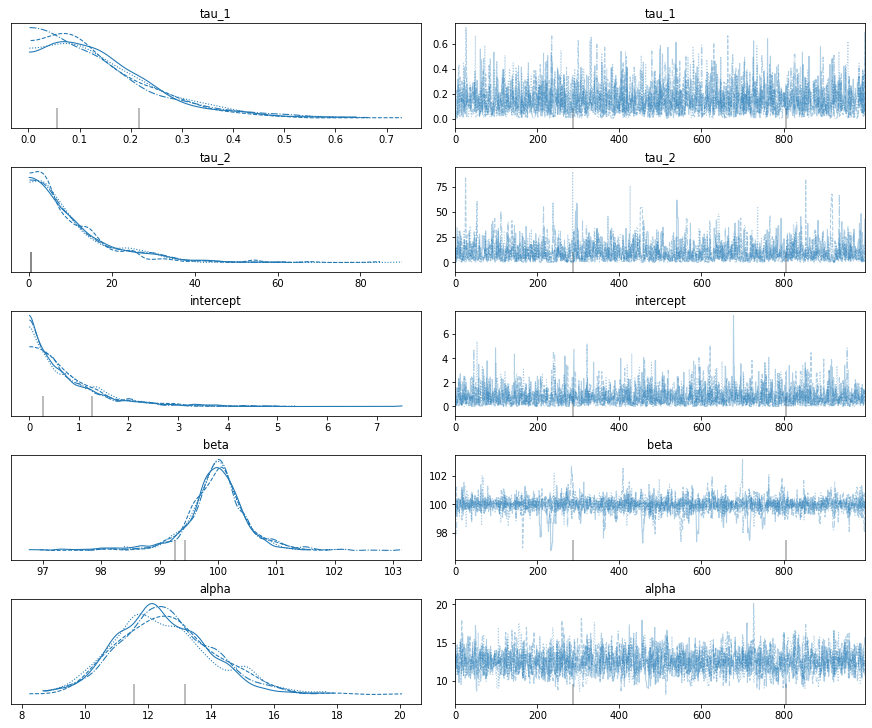

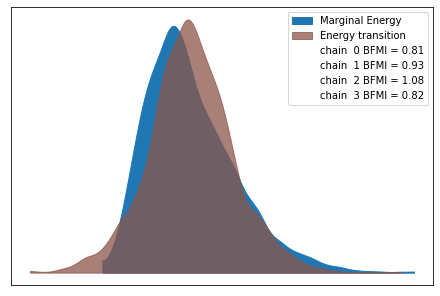

In [19]:
az.plot_trace(linear_neg_binomial_trace)
az.plot_energy(linear_neg_binomial_trace)
az.summary(linear_neg_binomial_trace)


In [20]:
with linear_neg_binomial_model:
    linear_neg_binomial_post_pred = pm.sample_posterior_predictive(
        linear_neg_binomial_trace.posterior
    )


In [21]:
plot_post_pred(linear_neg_binomial_post_pred, num_series=30, upper_bound=30_000)


(4020, 3)


alt.HConcatChart(...)

In [22]:
plot_residuals(linear_neg_binomial_post_pred, num_series=30)


(4020, 3)


alt.Chart(...)

In [23]:
# Second modeling attempt to account for the rapid incrase in new cases
with pm.Model() as exponential_model:
    # Define priors

    # We know the intercept should be 0, therefore the variance around
    #   the intercept should be small.
    tau_1 = pm.Gamma("tau_1", alpha=1, beta=10)

    # Define failrly non-informative priors for beta, however, after
    #   many trials, these parameters sampled well. mu has a higher alpha
    #   suggesting, we are more sure taht the slope should be closer to 0,
    mu = pm.Gamma("mu", alpha=1, beta=0.1)
    tau_2 = pm.Gamma("tau_2", alpha=0.1, beta=0.1)

    # Error/spread term as a gamma distribution rather than normal
    #    for new likelihood function
    alpha = pm.Gamma("alpha", alpha=36, beta=0.1)

    # Intercept - Can't have negative cumulative cases, HalfNormal dist
    #   forces mean of 0
    intercept = pm.HalfNormal("intercept", tau=tau_1)

    # Slope - Can't have negative slope of cumulative cases
    # beta = pm.HalfNormal('beta', sigma = 10)
    beta = pm.Bound(pm.Normal, lower=0)("beta", mu=mu, tau=tau_2)

    # Exponential regression
    growth = intercept * (1 + beta) ** us_delta.t.values

    # Negative Binomial Likelihood with gamma prior on alpha
    #   should be more appropiate to this problem than the previous
    #   since obs is a count (discrete), that is larger than 0.
    pm.NegativeBinomial(
        "obs", mu=growth, alpha=alpha, observed=us_delta.new_cumulative_cases.values
    )


obs ~ NegativeBinomial

In [24]:
with exponential_model:
    exponential_trace = pm.sample(
        chains=4, cores=4, return_inferencedata=True, tune=5000
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept, alpha, tau_2, mu, tau_1]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 9 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot:title={'center':'tau_1'}>,
        <AxesSubplot:title={'center':'tau_1'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'tau_2'}>,
        <AxesSubplot:title={'center':'tau_2'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

<AxesSubplot:>

mean       sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau_1         0.000    0.000    0.000     0.000      0.000    0.000    1667.0   
mu            2.284    3.935    0.000     7.998      0.093    0.066    1339.0   
tau_2         2.122    4.430    0.000     8.984      0.085    0.060    1364.0   
alpha         4.477    0.430    3.655     5.256      0.009    0.007    2154.0   
intercept  1055.495  104.615  859.770  1241.539      2.753    1.954    1465.0   
beta          0.025    0.001    0.023     0.028      0.000    0.000    1429.0   

           ess_tail  r_hat  
tau_1        1568.0    1.0  
mu           1566.0    1.0  
tau_2        1472.0    1.0  
alpha        2221.0    1.0  
intercept    1504.0    1.0  
beta         1420.0    1.0

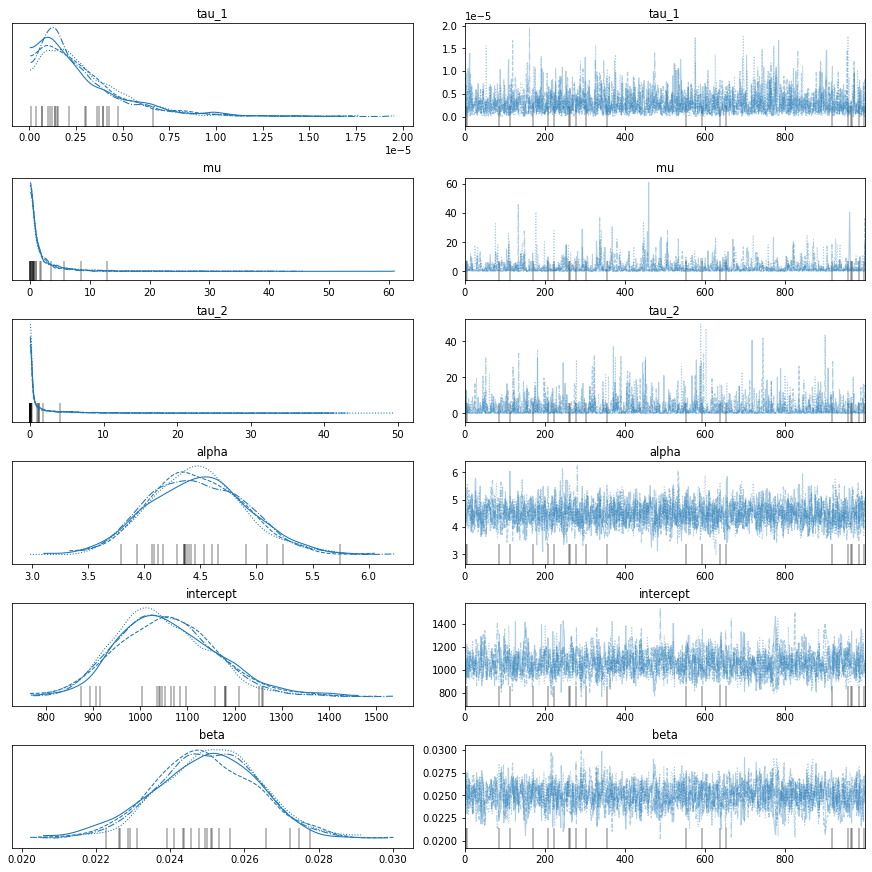

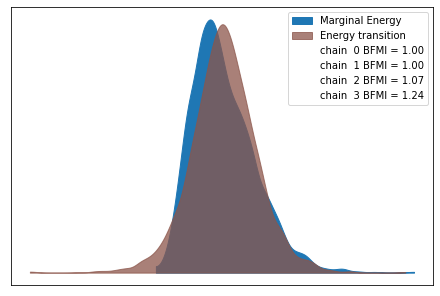

In [25]:
az.plot_trace(exponential_trace)
az.plot_energy(exponential_trace)
az.summary(exponential_trace)


In [26]:
with exponential_model:
    exponential_post_pred = pm.sample_posterior_predictive(exponential_trace)


In [27]:
plot_post_pred(exponential_post_pred, num_series=30, upper_bound=100_000)


(4020, 3)


alt.HConcatChart(...)

In [28]:
plot_residuals(exponential_post_pred, num_series=30)


(4020, 3)


alt.Chart(...)

In [29]:
with pm.Model() as logistic_model:
    # Define failrly informative priors for Intercept, however, after
    #   many trials, these parameters sampled well.
    mu_1 = pm.Gamma("mu_1", alpha=1, beta=1)
    tau_1 = pm.Gamma("tau_1", alpha=1, beta=1)

    # Define failrly informative priors for beta, however, after
    #   many trials, these parameters sampled well.
    mu_2 = pm.Gamma("mu_2", alpha=1, beta=10)
    tau_2 = pm.Gamma("tau_2", alpha=1, beta=10)

    # Error/spread term as a gamma distribution rather than normal
    #    for new likelihood function
    alpha = pm.Gamma("alpha", alpha=10, beta=10)

    # Intercept - Can't have negative cumulative cases, HalfNormal dist
    #   forces mean of 0
    intercept = pm.Bound(pm.Normal, lower=0)("intercept", mu=mu_1, tau=tau_1)

    # Slope - Can't have negative slope of cumulative cases
    # beta = pm.HalfNormal('beta', sigma = 10)
    beta = pm.Bound(pm.Normal, lower=0)("beta", mu=mu_2, tau=tau_2)

    # Set Limits for logistic growth function
    #   Lower limit is 0, upper limit is roughly the US population
    limits = pm.Uniform("limits", lower=0, upper=331_500)

    # Logistic regression - however not for classification
    a = limits / intercept - 1
    growth = limits / (1 + a * pm.math.exp(-beta * us_delta.t.values))

    # Negative Binomial Likelihood with gamma prior on alpha
    #   should be more appropiate to this problem than the previous
    #   since obs is a count (discrete), that is larger than 0.
    pm.NegativeBinomial(
        "obs", mu=growth, alpha=alpha, observed=us_delta.new_cumulative_cases.values
    )


obs ~ NegativeBinomial

In [30]:
with logistic_model:
    logistic_trace = pm.sample(chains=4, cores=4, return_inferencedata=True, tune=5000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [limits, beta, intercept, alpha, tau_2, mu_2, tau_1, mu_1]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 9 seconds.


array([[<AxesSubplot:title={'center':'mu_1'}>,
        <AxesSubplot:title={'center':'mu_1'}>],
       [<AxesSubplot:title={'center':'tau_1'}>,
        <AxesSubplot:title={'center':'tau_1'}>],
       [<AxesSubplot:title={'center':'mu_2'}>,
        <AxesSubplot:title={'center':'mu_2'}>],
       [<AxesSubplot:title={'center':'tau_2'}>,
        <AxesSubplot:title={'center':'tau_2'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'limits'}>,
        <AxesSubplot:title={'center':'limits'}>]], dtype=object)

<AxesSubplot:>

mean       sd    hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
mu_1           1.034    1.058     0.000      2.951      0.017    0.013   
tau_1          0.000    0.000     0.000      0.000      0.000    0.000   
mu_2           0.103    0.099     0.000      0.283      0.002    0.001   
tau_2          0.147    0.122     0.001      0.370      0.002    0.001   
alpha          4.923    0.553     3.955      6.025      0.010    0.007   
intercept    146.987   26.291    99.741    195.836      0.651    0.460   
beta           0.103    0.009     0.086      0.119      0.000    0.000   
limits     10764.147  638.841  9567.162  11910.808     11.677    8.276   

           ess_bulk  ess_tail  r_hat  
mu_1         2515.0    1332.0    1.0  
tau_1        2701.0    2137.0    1.0  
mu_2         2713.0    1822.0    1.0  
tau_2        2798.0    1629.0    1.0  
alpha        3400.0    2209.0    1.0  
intercept    1622.0    2220.0    1.0  
beta         1554.0    1920.0    1.0  
limits       3013.0    2567.0    1.0

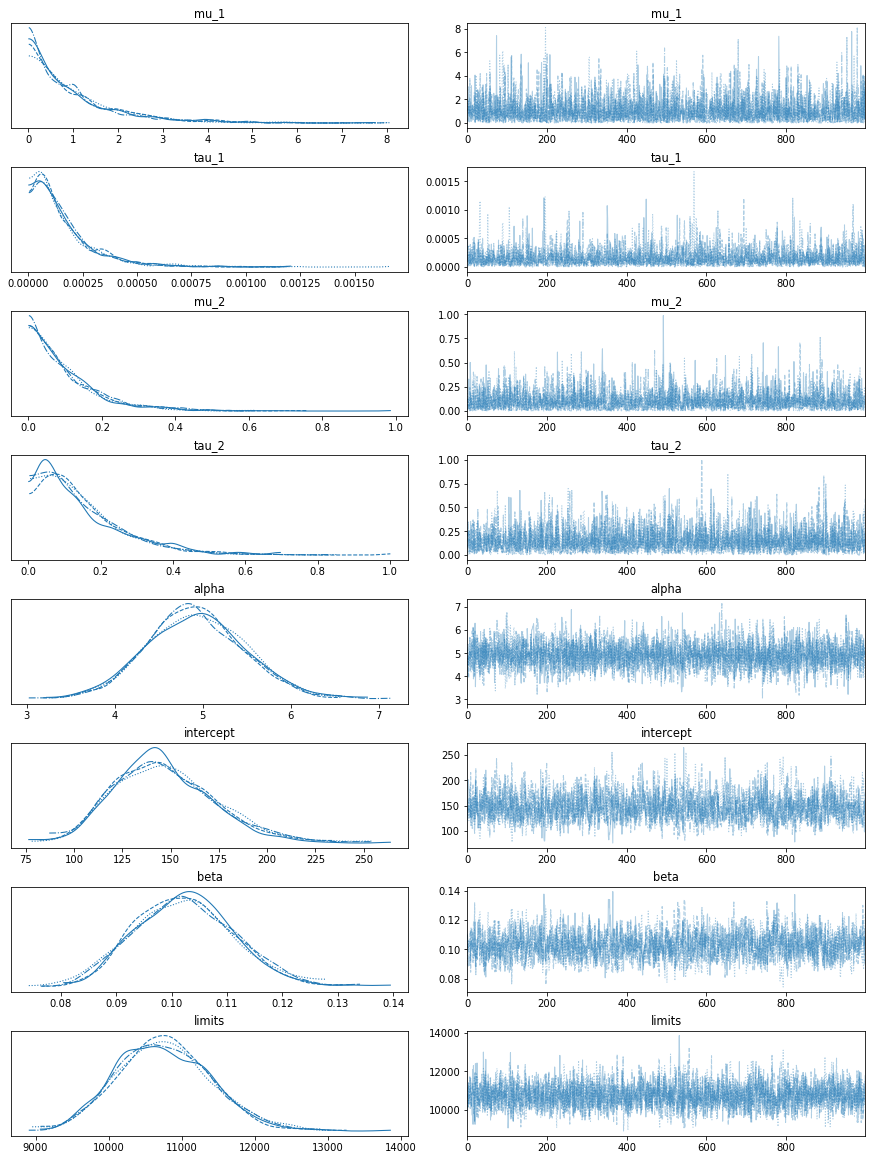

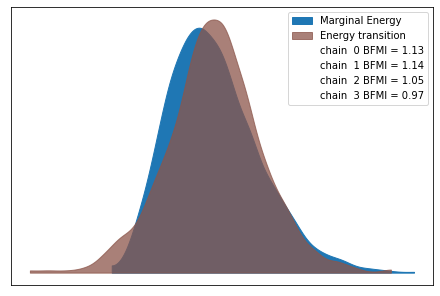

In [31]:
az.plot_trace(logistic_trace)
az.plot_energy(logistic_trace)
az.summary(logistic_trace)


In [32]:
with logistic_model:
    logistic_post_pred = pm.sample_posterior_predictive(logistic_trace.posterior)


In [33]:
plot_post_pred(logistic_post_pred, num_series=30)


(4020, 3)


alt.HConcatChart(...)

In [34]:
plot_residuals(logistic_post_pred, num_series=30)


(4020, 3)


alt.Chart(...)

# Model Comparison and Conclusion

In [35]:
model_dict = {
    "linear_normal": linear_normal_trace,
    "linear_negative_binomial": linear_neg_binomial_trace,
    "exponential": exponential_trace,
    "logistic": logistic_trace,
}


In [36]:
az.compare(model_dict, "loo")


/home/alexkeeney/anaconda3/envs/bs/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/alexkeeney/anaconda3/envs/bs/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank          loo     p_loo       d_loo  \
linear_normal                0 -1040.848027  1.100335    0.000000   
linear_negative_binomial     1 -1151.811321  2.264776  110.963294   
logistic                     2 -1183.572653  4.410994  142.724626   
exponential                  3 -1267.457035  8.613495  226.609008   

                                weight         se        dse  warning  \
linear_normal             9.848488e-01   4.236006   0.000000    False   
linear_negative_binomial  1.515119e-02  10.034295  11.101831    False   
logistic                  0.000000e+00  15.621864  16.911936    False   
exponential               6.889755e-11  20.610704  22.426342     True   

                         loo_scale  
linear_normal                  log  
linear_negative_binomial       log  
logistic                       log  
exponential                    log

In [37]:
az.compare(model_dict, "WAIC")


/home/alexkeeney/anaconda3/envs/bs/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/alexkeeney/anaconda3/envs/bs/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/alexkeeney/anaconda3/envs/bs/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/alexkeeney/anaconda3/envs/bs/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance o

rank         waic    p_waic      d_waic  \
linear_normal                0 -1040.847804  1.100112    0.000000   
linear_negative_binomial     1 -1151.738452  2.191907  110.890648   
logistic                     2 -1183.566566  4.404907  142.718762   
exponential                  3 -1267.404415  8.560875  226.556611   

                                weight         se        dse  warning  \
linear_normal             9.847118e-01   4.235996   0.000000    False   
linear_negative_binomial  1.528817e-02  10.086362  11.145663     True   
logistic                  3.222334e-12  15.621454  16.911423     True   
exponential               1.027336e-09  20.589298  22.405611     True   

                         waic_scale  
linear_normal                   log  
linear_negative_binomial        log  
logistic                        log  
exponential                     log

## Conclusion

Both WAIC and LOO prefer the simplest linear model to all others, despite the log-scale posterior predictive charts appearing to favor the logistic model. Each model has a unique flaw based on the expected shape of the posterior. The linear model will not predict any change in slope over time, while the exponential model will never predict a reduction in slope. However, the observed cumulative case data resembles an exponential growth early on and a leveling off. By this argument, we would expect the logistic model to perform best, however, due to the "s" shape of the sigmoid family of curves, the logistic model is bound to eventually predict a leveling off of cumulative cases after an exponential increase; which leads to a poor fit for this particular time frame due to the second increase in slope after an initial leveling off. 

In [38]:
alt.Chart(us_delta).mark_line().encode(x="Date_reported:T", y="New_cases") | alt.Chart(
    us_delta
).mark_line().encode(x="Date_reported:T", y="new_cumulative_cases")


alt.HConcatChart(...)

As seen in the charts above, infections increase exponentially early on, then new infections decrease just as rapidly after peaking in early September until late October. This leads to a sigmoid/logit-like shape of cumulative cases over this period. However, new cases begin to increase again in late October, leading to the second increase in the slope of cumulative cases. This second increase in the rate of new cases limits the effectiveness of a logistic model, which is unable to model a second exponential increase in rate.

To improve the fit of this model further, one would want to try an autoregressive time-series model that accounts for seasonal changes, public policy changes, and other external factors that make this problem fundamentally non-stationary. 

If above hyper link did not work, data source: <https://covid19.who.int/info?openIndex=2>

Inspiration for this project was taken from the Thomas Wiecki talk: The Bayesian Workflow: Building a COVID-19 Model by Thomas Wiecki, available here: <https://discourse.pymc.io/t/the-bayesian-workflow-building-a-covid-19-model-by-thomas-wiecki/6017> . I use different methods, data, and ultimately come to a different conclusion than the original talk.
